In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The dataset

In [2]:
X = np.load('./raw_data/X.npy')
y = np.load('./raw_data/y.npy')

In [3]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (25000, 10, 3)
y.shape = (25000,)


__Comments__:

- the shape (25000, 10, 3) means:
    - 25000 employees
    - 10 points (years) of data
    - 3 types of data (salary, responsibility and company size) 

Let's look at the data of the first employee

In [4]:
employee_0 = pd.DataFrame(X[0],
                         columns=['salary',
                                 'responsibility',
                                 'company_size'])

round(employee_0, 2)

,salary,responsibility,company_size
0,0.80,10.73,102.0
1,0.50,10.73,102.0
2,0.60,10.73,102.0
3,0.71,10.73,130.0
4,0.94,10.73,130.0
5,1.05,10.73,130.0
6,1.12,32.00,108.0
7,4.87,32.00,108.0
8,4.97,33.00,108.0
9,5.20,39.00,108.0


__goal__: predict the monthly salary on the 11th year for each of these 25,000 employees, based on the past observations

In [5]:
# for example, the first employee earns 6.499 k USD per month durin the 11th year at the company
y[0]

6.499

## Data visualization

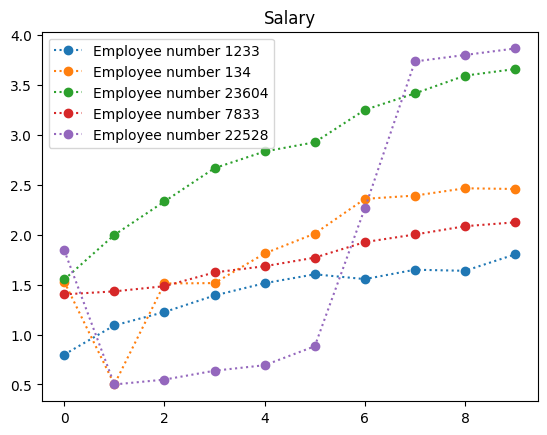

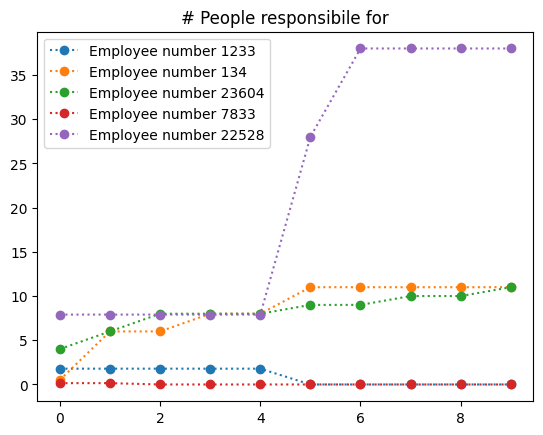

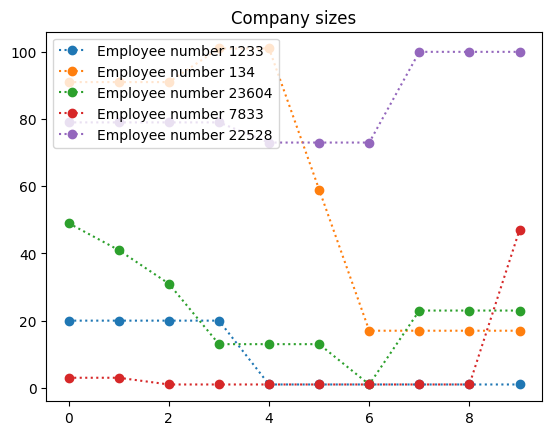

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

number_of_employees = len(X)

### Choosing random employees
##### As the employees are selected randomly, feel free to re-run this cell a few times !

number_of_randomly_selected_employees = 5

random_selection = np.random.randint(0, 
                                     number_of_employees,
                                     number_of_randomly_selected_employees)


### Plotting data for the selected employees

plt.title('Salary')
for r in random_selection:
    plt.plot(X[r, :, 0],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('# People responsibile for')
for r in random_selection:
    plt.plot(X[r, :, 1],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

plt.title('Company sizes')
for r in random_selection:
    plt.plot(X[r, :, 2],label=f"Employee number {r}",linestyle=":",marker="o")
    plt.legend(loc='upper left')
plt.show()

__Data exploration__ Looking a the distribution of:

- all the salaries during the 10th year
- people under someone's responsibility
- and the company sizes

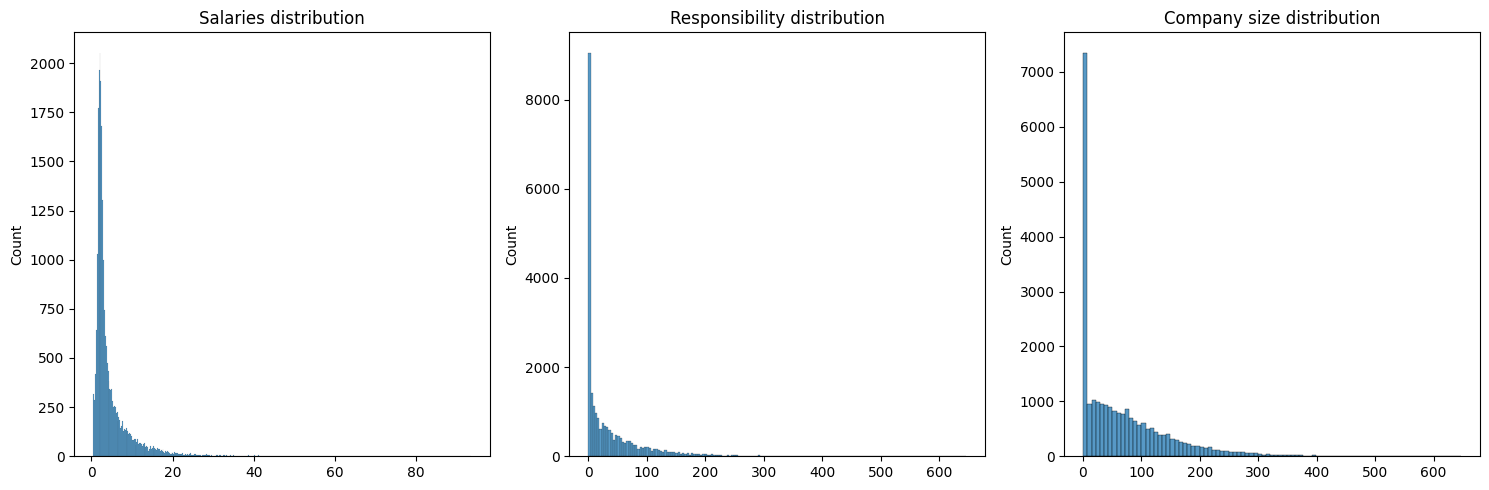

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# distribution of all salaries during the 10th year
sns.histplot(X[:, -1, 0].flatten(), ax=axs[0])
axs[0].set_title('Salaries distribution')

# distribution of responsibility during the 10th year
sns.histplot(X[:, -1, 1].flatten(), ax=axs[1])
axs[1].set_title('Responsibility distribution')

# distribution of company size during the 10th year
sns.histplot(X[:, -1, 2].flatten(), ax=axs[2])
axs[2].set_title('Company size distribution')

plt.tight_layout()
plt.show()

## Hold-out method

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (20000, 10, 3)
y_train.shape = (20000,)
X_test.shape = (5000, 10, 3)
y_test.shape = (5000,)


# Simple RNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Normalization, Dense, SimpleRNN

normalizer = Normalization()
normalizer.adapt(X_train)

model = Sequential()
model.add(normalizer)
model.add(SimpleRNN(units=20, activation='tanh')) # better suited for a Recurrent Layer
model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20)                480       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 708
Trainable params: 701
Non-trainable params: 7
_________________________________________________________________


In [10]:
X_train.shape

(20000, 10, 3)

In [11]:
# simple rnn
(7*20+20)*3

480

In [12]:
# first dense layer
(20*10+10)

210

In [13]:
# second predictive layer
(10*1+1)

11

- _Normalization layer_:
    - this layer has n_x = 3 features (salary, responsibility and company_size) to normalize. Each of them requires to compute the mean and the standard_deviation. So, we have n_x = 3 x 2 = 6 non-trainable parameters. The 7th parameter is a bias initially set to 0.
    
    
- _Recurrent layer_:
    - if n_h = 20 RNN units are applied in parallel to n_x = 3 features, then the Recurrent layer has n_h(n_h + n_x + 1) = 20 x (20 + 3 + 1) = (20 x 24) = 480 parameters to train.
    - notice how this number is independent of the length of each sequence (here 10 days)
    
    
- _Dense layer_:
    - starting with n_h = 20 RNN units and 1 bias, using 10 neurons, the Dense Layer has (20 + 1) x 10 = 21 x10 = 210 parameters
    

- _Predictive Dense layer_:
    - starting with 10 neurons and 1 bias, 1 neuron to predict the 11th salary, the Predictive Dense layer has (10 + 1) x 1 = 11 x 1 = 11 parameters

In [14]:
def compile_model(model):
    model.compile(loss='mse',
                 optimizer='rmsprop',
                 metrics=['mae'])
    return model

model = compile_model(model)

In [15]:
%%time
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                   validation_split=0.2,
                   batch_size=32,
                   epochs=100,
                   callbacks=[es],
                   verbose=1)

Epoch 1/100
500/500 [==============================] - 2s 2ms/step - loss: 22.6685 - mae: 2.0406 - val_loss: 4.9166 - val_mae: 0.7325
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 3.4580 - mae: 0.5498 - val_loss: 1.4824 - val_mae: 0.4479
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 1.6574 - mae: 0.4077 - val_loss: 0.9458 - val_mae: 0.3631
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 1.1907 - mae: 0.3716 - val_loss: 0.7593 - val_mae: 0.3048
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 1.0058 - mae: 0.3526 - val_loss: 0.7111 - val_mae: 0.3224
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 0.9105 - mae: 0.3485 - val_loss: 0.6651 - val_mae: 0.2904
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.8610 - mae: 0.3416 - val_loss: 0.5962 - val_mae: 0.2767
Epoch 8/100
500/500 [==============================] - 1s 2ms/step -

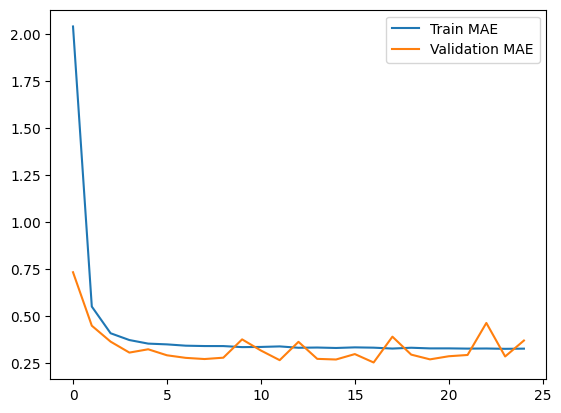

In [18]:
plt.plot(history.history["mae"], label = "Train MAE")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.legend()

In [20]:
model_mae = model.evaluate(X_test, y_test, verbose=0)
print(f'Model Absolute Error = {round(model_mae[1], 4)}')

Model Absolute Error = 0.2885


In [21]:
model_mae

[0.569374680519104, 0.2885439991950989]

# Baseline comparison

Our goal is to predict the salary of the employees for the 11th year. It's a regression task. What baseline should be built?


- In the case of a traditional regression model, a baseline prediction for __y_test__ is to predict the average of __y_train__ but this option could be irrelevant for time-related series. Theoretically, someone's salary is supposed to increase over the years.


- an alternative baseline prediction for a regression task is to __predict the last seen value__.


- Let's compute the Mean Absolute Error of a baseline model that predicts that the salary remains constant between the 10-th and 11-th year.

In [22]:
def constant_prediction(X, y):
    errors = []
    for xx, yy in zip(X, y):
        last_salary = xx[-1][0] # using the 10th salary to predict the 11th salary
        errors.append(yy - last_salary)
        
    return errors

In [23]:
errors_baseline = constant_prediction(X, y)
mae_baseline = np.mean(np.abs(errors_baseline))

print(f'Baseline MAE = {round(mae_baseline, 4)}')
print(f'vs')
print(f'RNN MAE = {round(model_mae[1], 4)}')

Baseline MAE = 0.5952
vs
RNN MAE = 0.2885


The RNN performs a bit better than a baseline model

# LSTM: Long Short Term Memory

In [26]:
from tensorflow.keras.layers import LSTM

normalizer = Normalization()
normalizer.adapt(X_train)

model_LSTM = Sequential()
model_LSTM.add(normalizer)
model_LSTM.add(LSTM(units=20, activation='tanh')) 
model_LSTM.add(Dense(units=10, activation='relu'))
model_LSTM.add(Dense(units=1, activation='linear'))

model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, None, 3)          7         
 ion)                                                            
                                                                 
 lstm_1 (LSTM)               (None, 20)                1920      
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,148
Trainable params: 2,141
Non-trainable params: 7
_________________________________________________________________


In [27]:
model_LSTM = compile_model(model_LSTM)

es = EarlyStopping(patience=5, restore_best_weights=True)

history_LSTM = model_LSTM.fit(X_train, y_train,
                             validation_split=0.2,
                             batch_size=32,
                             epochs=100,
                             callbacks=[es],
                             verbose=1)

Epoch 1/100
500/500 [==============================] - 2s 3ms/step - loss: 16.0561 - mae: 1.7150 - val_loss: 3.2081 - val_mae: 0.7105
Epoch 2/100
500/500 [==============================] - 1s 3ms/step - loss: 2.3957 - mae: 0.5133 - val_loss: 1.2427 - val_mae: 0.5090
Epoch 3/100
500/500 [==============================] - 1s 3ms/step - loss: 1.2027 - mae: 0.3547 - val_loss: 0.7278 - val_mae: 0.3005
Epoch 4/100
500/500 [==============================] - 1s 3ms/step - loss: 0.9575 - mae: 0.3233 - val_loss: 0.6625 - val_mae: 0.3072
Epoch 5/100
500/500 [==============================] - 1s 3ms/step - loss: 0.8429 - mae: 0.3097 - val_loss: 0.5770 - val_mae: 0.2567
Epoch 6/100
500/500 [==============================] - 1s 3ms/step - loss: 0.7640 - mae: 0.3069 - val_loss: 0.5771 - val_mae: 0.2682
Epoch 7/100
500/500 [==============================] - 1s 3ms/step - loss: 0.7361 - mae: 0.3017 - val_loss: 0.5199 - val_mae: 0.2583
Epoch 8/100
500/500 [==============================] - 1s 3ms/step -

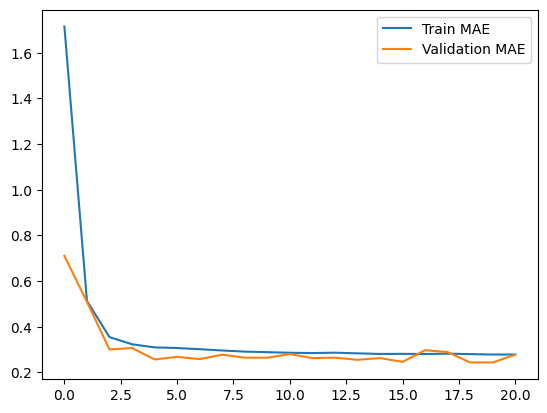

In [30]:
plt.plot(history_LSTM.history["mae"], label = "Train MAE")
plt.plot(history_LSTM.history["val_mae"], label = "Validation MAE")
plt.legend()
plt.show()